In [21]:
# test pickle seems pretty good!

from joblib import load, dump
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from rasterio.plot import reshape_as_image
import matplotlib.patches as mpatches
from TOA_Reflectance_Stacker import histogram_stretch

In [2]:
estimator = load('Machine Learning Models/supervised_linearsvc_tuned.joblib')

In [9]:
with rio.open('LC08_L2SP_113037_20210104_20210308_02_T1/LC08_L2SP_113037_20210104_20210308_02_T1_STACKED.tif') as src:
    stack = src.read()
    profile = src.profile
    src.close()
    
# change the stack from DNs to reflectances
# remember temperature uses a different scaling factor (temp is in Kelvin)
scaled_stack = stack[:-1,...] * 0.0000275 - 0.2
scaled_temp = stack[-1,...] * 0.00341802 + 149.0 

scaled_stack = np.vstack((scaled_stack, np.expand_dims(scaled_temp, axis = 0))) # need to change scaled_temp from 2D to 3D

# Reshape our image into rows of pixels and columns of bands
X_test = scaled_stack.swapaxes(0,2).reshape(-1, 8)

y_pred = estimator.predict(X_test)

# Get back the original image
nagasaki_pred = y_pred.reshape(scaled_stack.shape[2], scaled_stack.shape[1]).T

# nagasaki_pred currently a bunch of strings - convert to integers
lulc_dict = dict((
    ("Urban", 0),
    ("Cropland", 1),
    ("Forest", 2),
    ("Water", 3),
    ("Bare Land", 4),
))

# Invert dictionary
inv_dict = {v: k for k, v in lulc_dict.items()}

# replace all pixels with numbers

# apparently faster - returns unique values as well as the indices that can be used to reconstruct
# the array
u, inv = np.unique(nagasaki_pred, return_inverse = True)
nagasaki_pred = np.array([lulc_dict[x] for x in u])[inv].reshape(nagasaki_pred.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


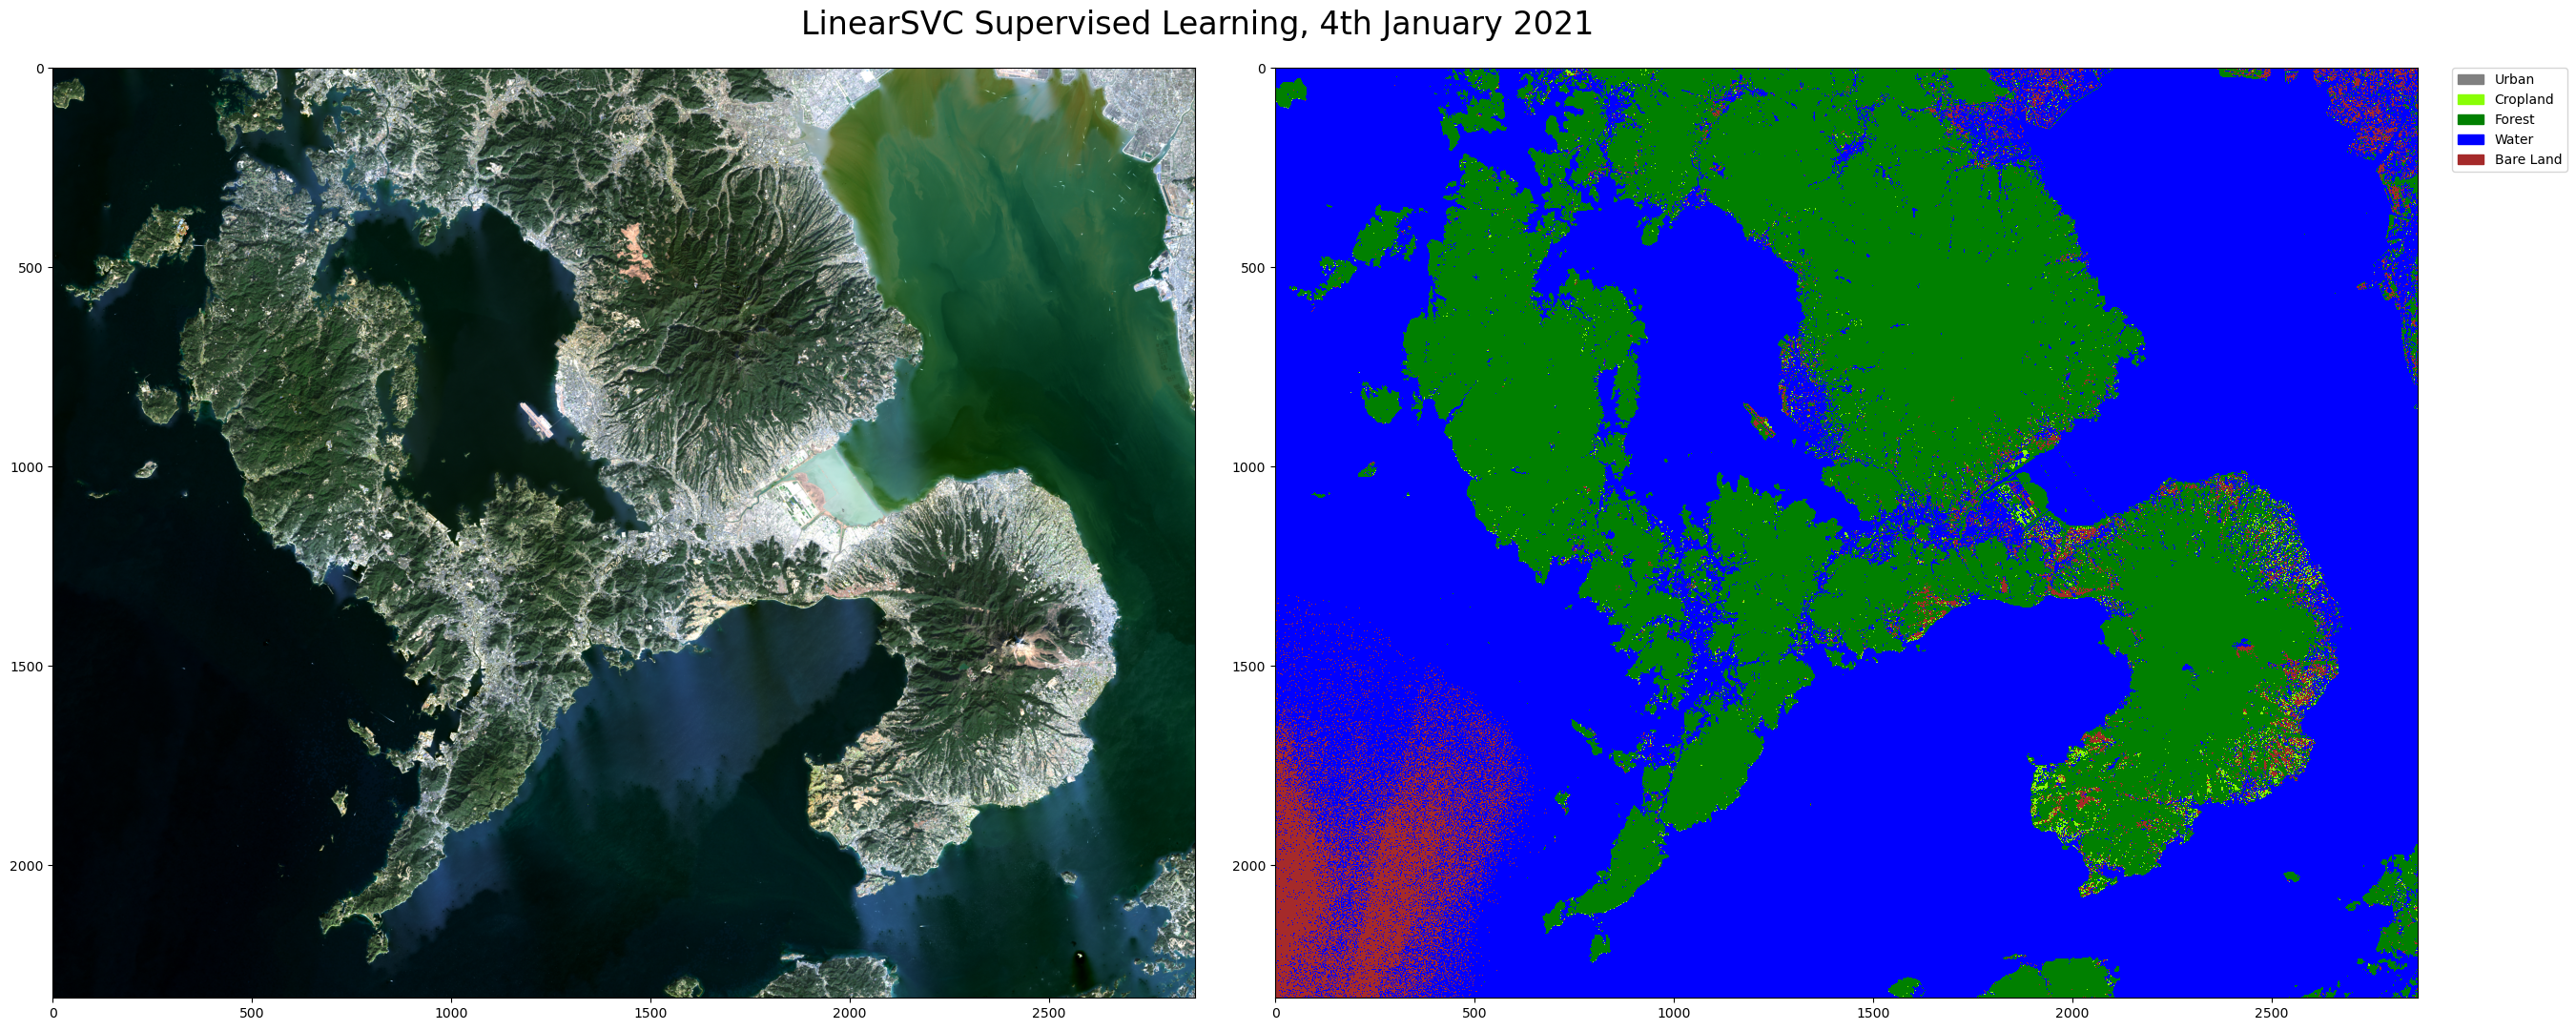

In [22]:
# unfortunately, does not work well on the different days
fig, ax = plt.subplots(1,2,figsize = (32,18), gridspec_kw={'wspace': 0.07})

colors = ["grey", "xkcd:lime green", "green", "blue", "brown"]
cmap = ListedColormap(colors)

ax[0].imshow(reshape_as_image(histogram_stretch(scaled_stack[[3,2,1]])))
ax[1].imshow(nagasaki_pred, cmap = cmap, interpolation='nearest')
# ax[1].imshow(cl_mask, alpha = 0.9 * cl_mask, cmap = "Greys_r")

fig.suptitle("LinearSVC Supervised Learning, 4th January 2021", y=.8, fontsize = 24)

patches = [mpatches.Patch(color=colors[i], label = inv_dict[i]) for i in range(len(np.unique(nagasaki_pred))) ]
plt.legend(handles=patches, bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0. )